If you want to see the graphs, set show_graphs to True. 

However, if the kernel crashes, please set it to False to avoid the issue.

In [ ]:
show_graphs=False

# 1. Imports

In [1]:
# General-purpose libraries
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# GPU-based libraries
import cupy as cp
import cudf
from cuml.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from cuml.decomposition import PCA
from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.model_selection import GridSearchCV as cuml_GridSearchCV

# CPU-based libraries
from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn.metrics import accuracy_score

# XGBoost (supports both CPU and GPU)
import xgboost as xgb

# Evaluation libraries
from sklearn.metrics import confusion_matrix, classification_report, roc_curve,roc_auc_score

# 2. Exploratory Data Analysis (EDA)

In [2]:
df_gpu=cudf.read_csv("Partical.csv")

## Data info and description 

We see that the dataset contains1000 1000 observations and the dataset hav28 9 classes and a target class. 

We also see in the result below that the dataset contains only float type lues.

In [57]:
def data_discription(df_gpu):
    print("Basic Info")
    print(df_gpu.info())
    print("\nSummary Statistics")
    print(df_gpu.describe())
data_discription(df_gpu)

Basic Info
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 11000000 entries, 0 to 10999999
Data columns (total 29 columns):
 #   Column                    Dtype
---  ------                    -----
 0   Target                    float64
 1   lepton_pT                 float64
 2   lepton_eta                float64
 3   lepton_phi                float64
 4   missing_energy_magnitude  float64
 5   missing_energy_phi        float64
 6   jet_1_pt                  float64
 7   jet_1_eta                 float64
 8   jet_1_phi                 float64
 9   jet_1_b-tag               float64
 10  jet_2_pt                  float64
 11  jet_2_eta                 float64
 12  jet_2_phi                 float64
 13  jet_2_b-tag               float64
 14  jet_3_pt                  float64
 15  jet_3_eta                 float64
 16  jet_3_phi                 float64
 17  jet_3_b-tag               float64
 18  jet_4_pt                  float64
 19  jet_4_eta                 float64
 20  jet_4_phi    

/home/msc1/miniconda3/envs/rapids-23.08/lib/python3.9/site-packages/cudf/core/dataframe.py:4852: FutureWarning: `datetime_is_numeric` is deprecated. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  warnings.warn(
/home/msc1/miniconda3/envs/rapids-23.08/lib/python3.9/site-packages/cudf/core/series.py:3166: FutureWarning: `datetime_is_numeric` is deprecated and will be removed in a future release. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  warnings.warn(


             Target     lepton_pT    lepton_eta    lepton_phi  \
count  1.100000e+07  1.100000e+07  1.100000e+07  1.100000e+07   
mean   5.299200e-01  9.914660e-01 -8.000000e-06 -1.300000e-05   
std    4.991040e-01  5.653780e-01  1.008827e+00  1.006346e+00   
min    0.000000e+00  2.746970e-01 -2.434976e+00 -1.742508e+00   
25%    0.000000e+00  5.907530e-01 -7.383220e-01 -8.719310e-01   
50%    1.000000e+00  8.533710e-01 -5.400000e-05 -2.410000e-04   
75%    1.000000e+00  1.236226e+00  7.382140e-01  8.709940e-01   
max    1.000000e+00  1.209891e+01  2.434868e+00  1.743236e+00   

       missing_energy_magnitude  missing_energy_phi      jet_1_pt  \
count              1.100000e+07        1.100000e+07  1.100000e+07   
mean               9.985360e-01        2.600000e-05  9.909150e-01   
std                6.000180e-01        1.006326e+00  4.749750e-01   
min                2.370000e-04       -1.743944e+00  1.375020e-01   
25%                5.768160e-01       -8.712080e-01  6.789930e-01   


## Missing Data 
The dataset dont containe any missing values

In [58]:
def missing_data(df_gpu):
    # Count total missing values in the dataset
    total_missing = df_gpu.isnull().sum().sum()

    # Count the number of rows with at least one missing value
    rows_with_missing = df_gpu.isnull().any(axis=1).sum()

    # Display the results
    print(f"Total missing values: {total_missing}")
    print(f"Rows with missing values: {rows_with_missing}")
missing_data(df_gpu)

Total missing values: 0
Rows with missing values: 0


## Class Distribution
We have a balanced dataset with a 53:47 ratio

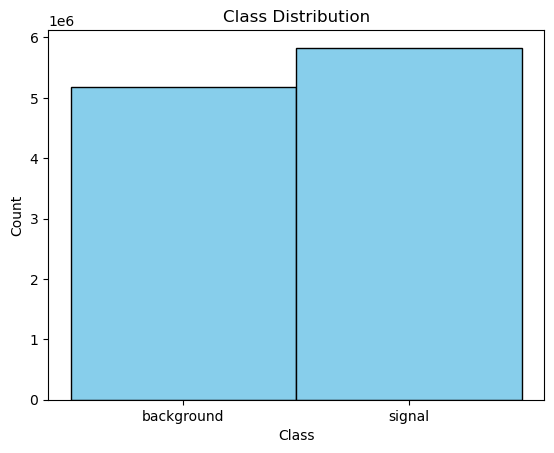

In [59]:
def class_distribution(df_gpu):
    plt.hist(df_gpu["Target"], bins=2, color='skyblue', edgecolor='black')
    plt.xticks([0.25, 0.75], ["background", "signal"])
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title("Class Distribution")
    plt.show()
if show_graphs:
    class_distribution(df_gpu)

## Data Distribution 
Several features in the dataset exhibit left-skewed distributions, including lepton_pT, missing_energy_magnitude, jet_1_pT, jet_2_pT, jet_3_pT, jet_4_pT, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, and m_wwbb. Additionally, the dataset shows a wide range of feature values, for example, missing_energy_magnitude and various jet transverse momentum (pT) values are significantly larger compared to other features. This inconsistency in value ranges could cause certain features to dominate the learning process, leading to suboptimal model performance. Although the remaining features generally follow a bell-shaped distribution, ideal for training, inconsistencies across feature scales still pose a challenge for effective model learning.

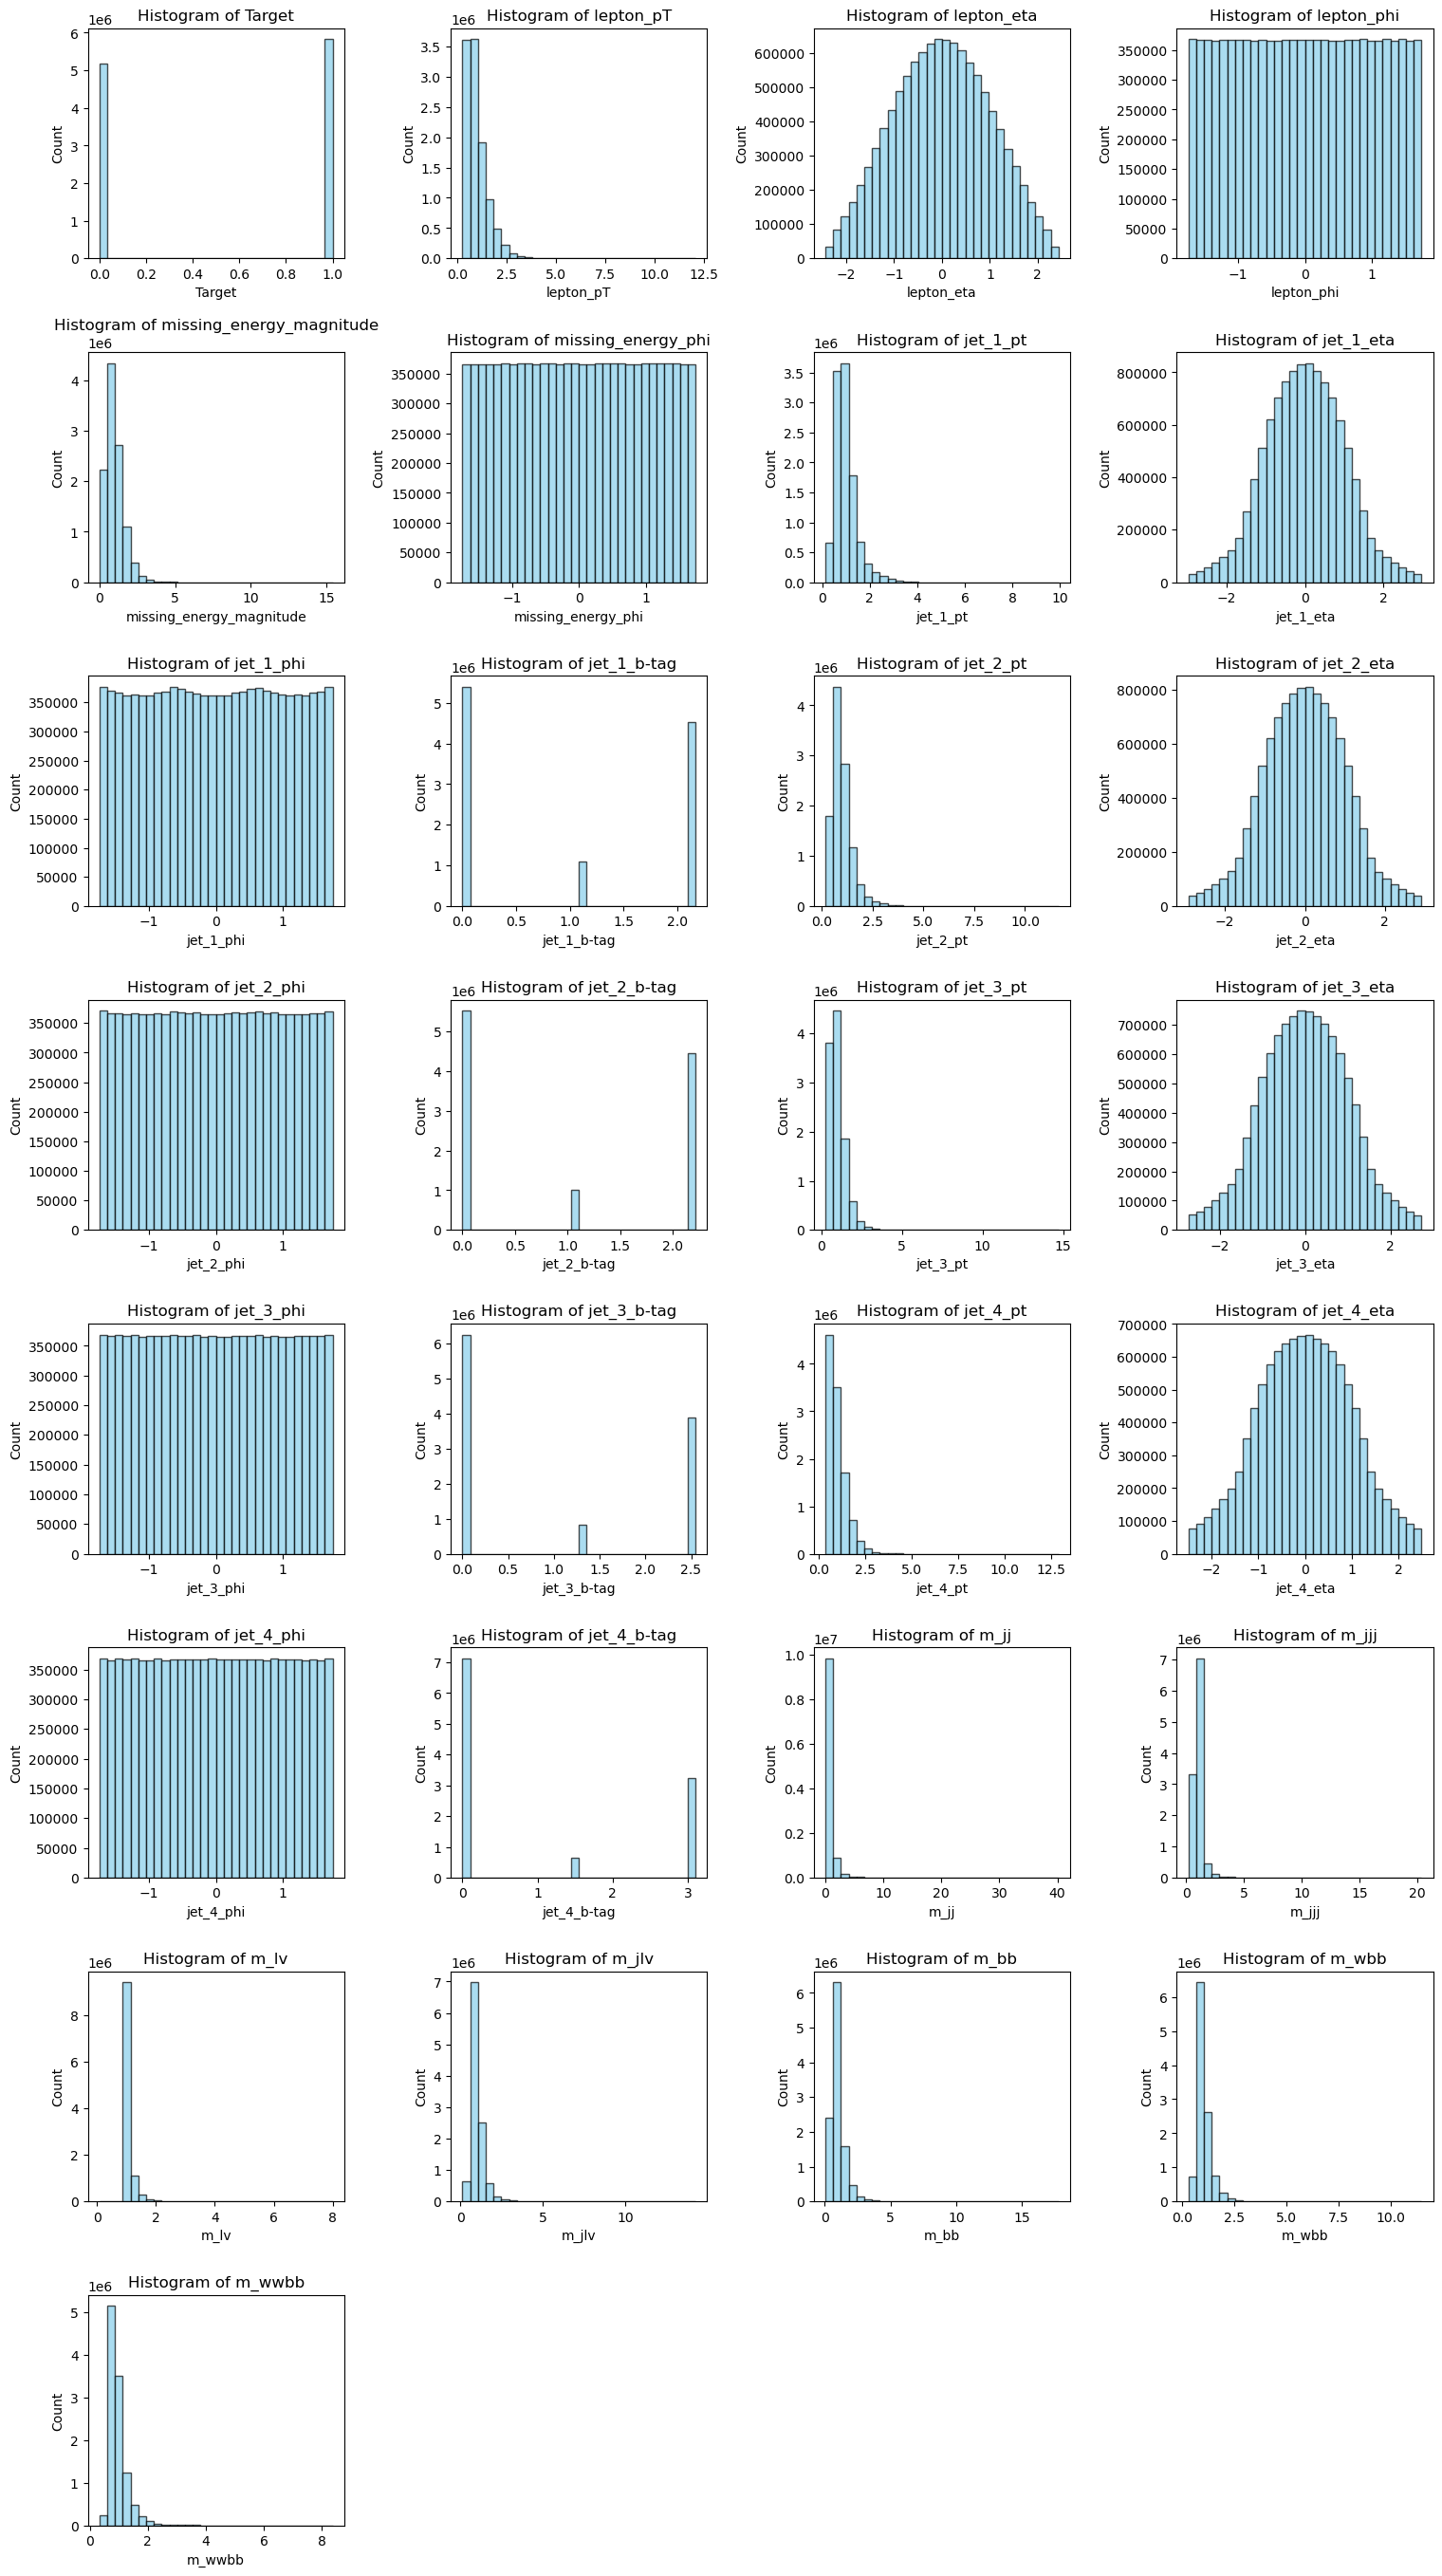

In [60]:
def display_data_disp(df_gpu):
    num_features = len(df_gpu.columns)
    num_rows = 8  # Adjusted to fit 28 features
    num_cols = 4  

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 28))
    fig.tight_layout(pad=5.0)

    # Flatten axes for easier iteration
    axes = axes.flatten()
    
    # Iterate through columns to create histograms
    for i, column in enumerate(df_gpu.columns):
        axes[i].hist(df_gpu[column], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        axes[i].set_title(f'Histogram of {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Count')
    
    # Hide any unused subplots (if total columns < grid size)
    for j in range(num_features, len(axes)):
        axes[j].axis('off')

    plt.show()

if show_graphs:
    display_data_disp(df_gpu)

## Outliers
the dataset has many outliers across different features. However, we can expect that most outliers are due to skewness left in the dataset, so by fixing the skewing in the features, most of the outliers will be delt with. For the remaining outliers we need to use imputation to remove them. 

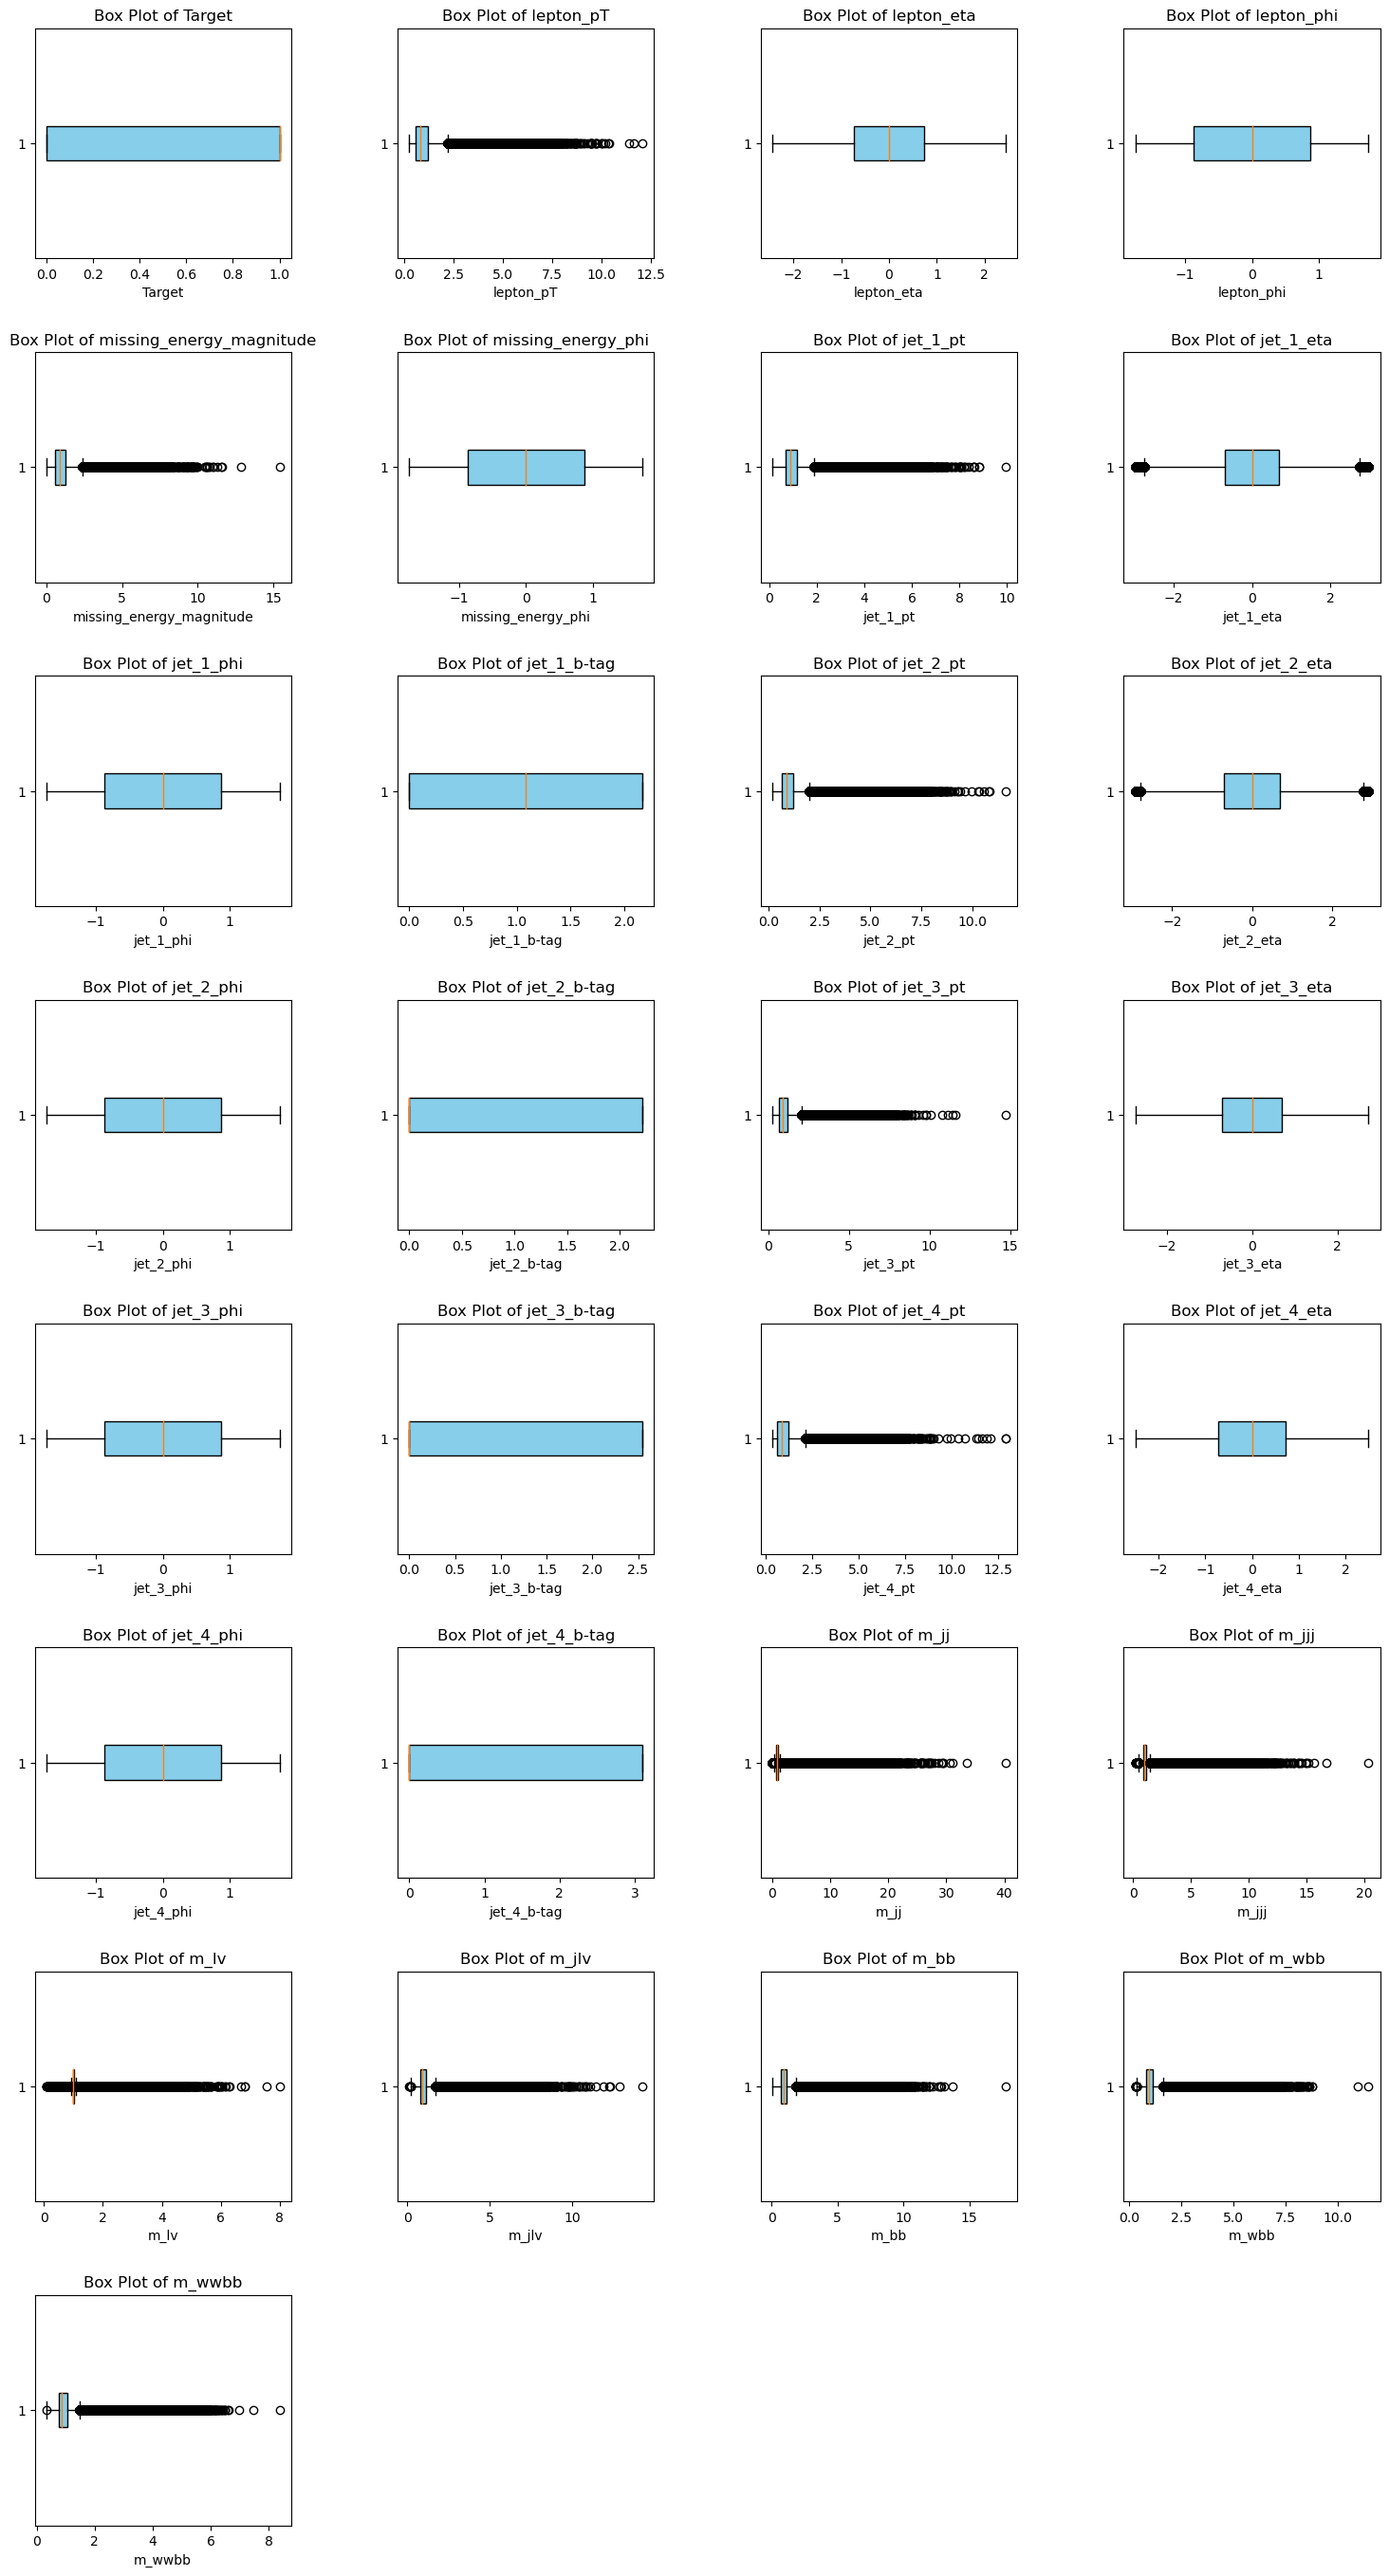

In [61]:
def display_outliers(df_gpu):
    numeric_columns = df_gpu.select_dtypes(include='number').columns
    num_features = len(numeric_columns)

    num_rows = 8  # Adjusted to fit 28 features
    num_cols = 4  

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 28))
    fig.tight_layout(pad=5.0)

    # Flatten axes for easier iteration
    axes = axes.flatten()
    
    # Iterate through numeric columns to create box plots
    for i, column in enumerate(numeric_columns):
        axes[i].boxplot(df_gpu[column], vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue'))
        axes[i].set_title(f'Box Plot of {column}')
        axes[i].set_xlabel(column)

    # Hide any unused subplots
    for j in range(num_features, len(axes)):
        axes[j].axis('off')

    plt.show()

if show_graphs:
    display_outliers(df_gpu)

## Correlation 
The dataset is fairly not correlated except for m_wwbb and m_wbb. which are highly correlated wich suggest removing one since they containe similare information

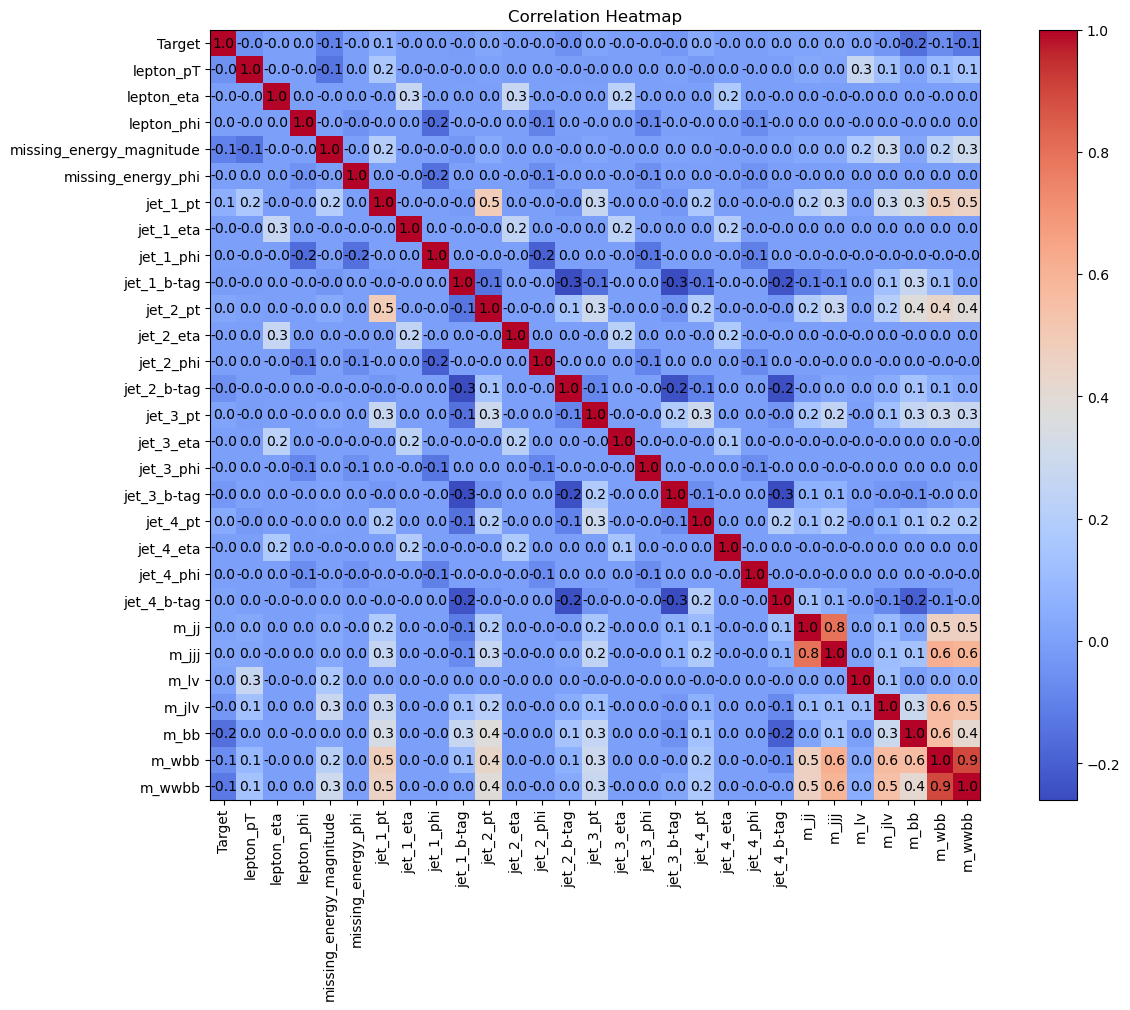

In [3]:
def correlation(df_gpu):
    corr_matrix = df_gpu.to_pandas().corr()  # Convert only for correlation computation

    plt.figure(figsize=(15, 10))
    plt.imshow(corr_matrix, cmap="coolwarm", interpolation="nearest")
    plt.colorbar()

    num_vars = len(corr_matrix.columns)
    for i in range(num_vars):
        for j in range(num_vars):
            plt.text(j, i, f"{corr_matrix.iloc[i, j]:.1f}", 
                     ha="center", va="center", color="black")

    plt.xticks(range(num_vars), corr_matrix.columns, rotation=90)
    plt.yticks(range(num_vars), corr_matrix.columns)
    plt.title("Correlation Heatmap")
    plt.show()

if show_graphs:
    correlation(df_gpu)

# 3. Data Preprocessing

In this section we will remove m_wwbb since it highly correlated with other features and we will fix the distrebution using Power Transformer and MinMaxScaler to get a set range of values

In [9]:
def fix_left_skewness_gpu(df, features):
    """
    Applies a PowerTransformer (Yeo-Johnson) to fix left-skewed features in a GPU-accelerated dataframe.

    Args:
        df (cudf.DataFrame): Input dataframe.
        features (list): List of feature names to transform.

    Returns:
        cudf.DataFrame: Transformed dataframe with reduced skewness.
    """
    df_transformed = df.copy()
    
    pt = PowerTransformer(method='yeo-johnson')
    
    # Apply PowerTransformer to the selected features
    df_transformed[features] = pt.fit_transform(df_transformed[features])
    
    return df_transformed

def normalize_data_gpu(df, batch_size=1_000_000):
    """
    Normalizes all features in the dataframe to the [0, 1] range using MinMaxScaler,
    processing in batches to handle large datasets on GPU.

    Args:
        df (cudf.DataFrame): Input dataframe to normalize.
        batch_size (int): Number of rows to process in each batch.

    Returns:
        cudf.DataFrame: Normalized dataframe.
    """
    scaler = MinMaxScaler()
    
    # Fit the scaler on the full dataset
    scaler.fit(df)
    
    # Initialize an empty dataframe for storing normalized batches
    df_normalized = cudf.DataFrame()
    
    # Manually setting number of batches, adjust as needed
    num_batches = 11  
    
    for i in range(num_batches):
        start = i * batch_size
        end = min((i + 1) * batch_size, len(df))
        
        # Extract a batch of data
        batch = df.iloc[start:end]
        
        # Normalize the batch
        normalized_batch = scaler.transform(batch)
        
        # Preserve the original column names
        normalized_batch.columns = df.columns
        
        # Append the normalized batch to the output dataframe
        df_normalized = cudf.concat([df_normalized, normalized_batch], ignore_index=True)
    
    return df_normalized
    
def set_target_variable(df):
    """
    Splits the dataframe into features (X) and target variable (y).

    Args:
        df (cudf.DataFrame): Input dataframe with a 'Target' column.

    Returns:
        X (cudf.DataFrame): Feature dataframe.
        y (cudf.Series): Target variable.
    """
    X = df.drop('Target', axis=1)
    y = df['Target']
    return X, y

## Set Target Variable

In [10]:
X,y=set_target_vriable(df_gpu)

## Remove Highly Correlated Fearures

In [11]:
X = X.drop('m_wwbb', axis=1)  # Drop 'm_wwbb' feature

## Fix Distrebution

In [12]:
features_list = [
    "lepton_pT", "missing_energy_magnitude", "jet_1_pt", "jet_2_pt", "jet_3_pt", "jet_4_pt", "m_jj", "m_jjj", "m_lv", "m_jlv", "m_bb", "m_wbb"
]

In [13]:
X=fix_left_skewness_gpu(X, features_list)

In [14]:
X=normalize_data_gpu(X)

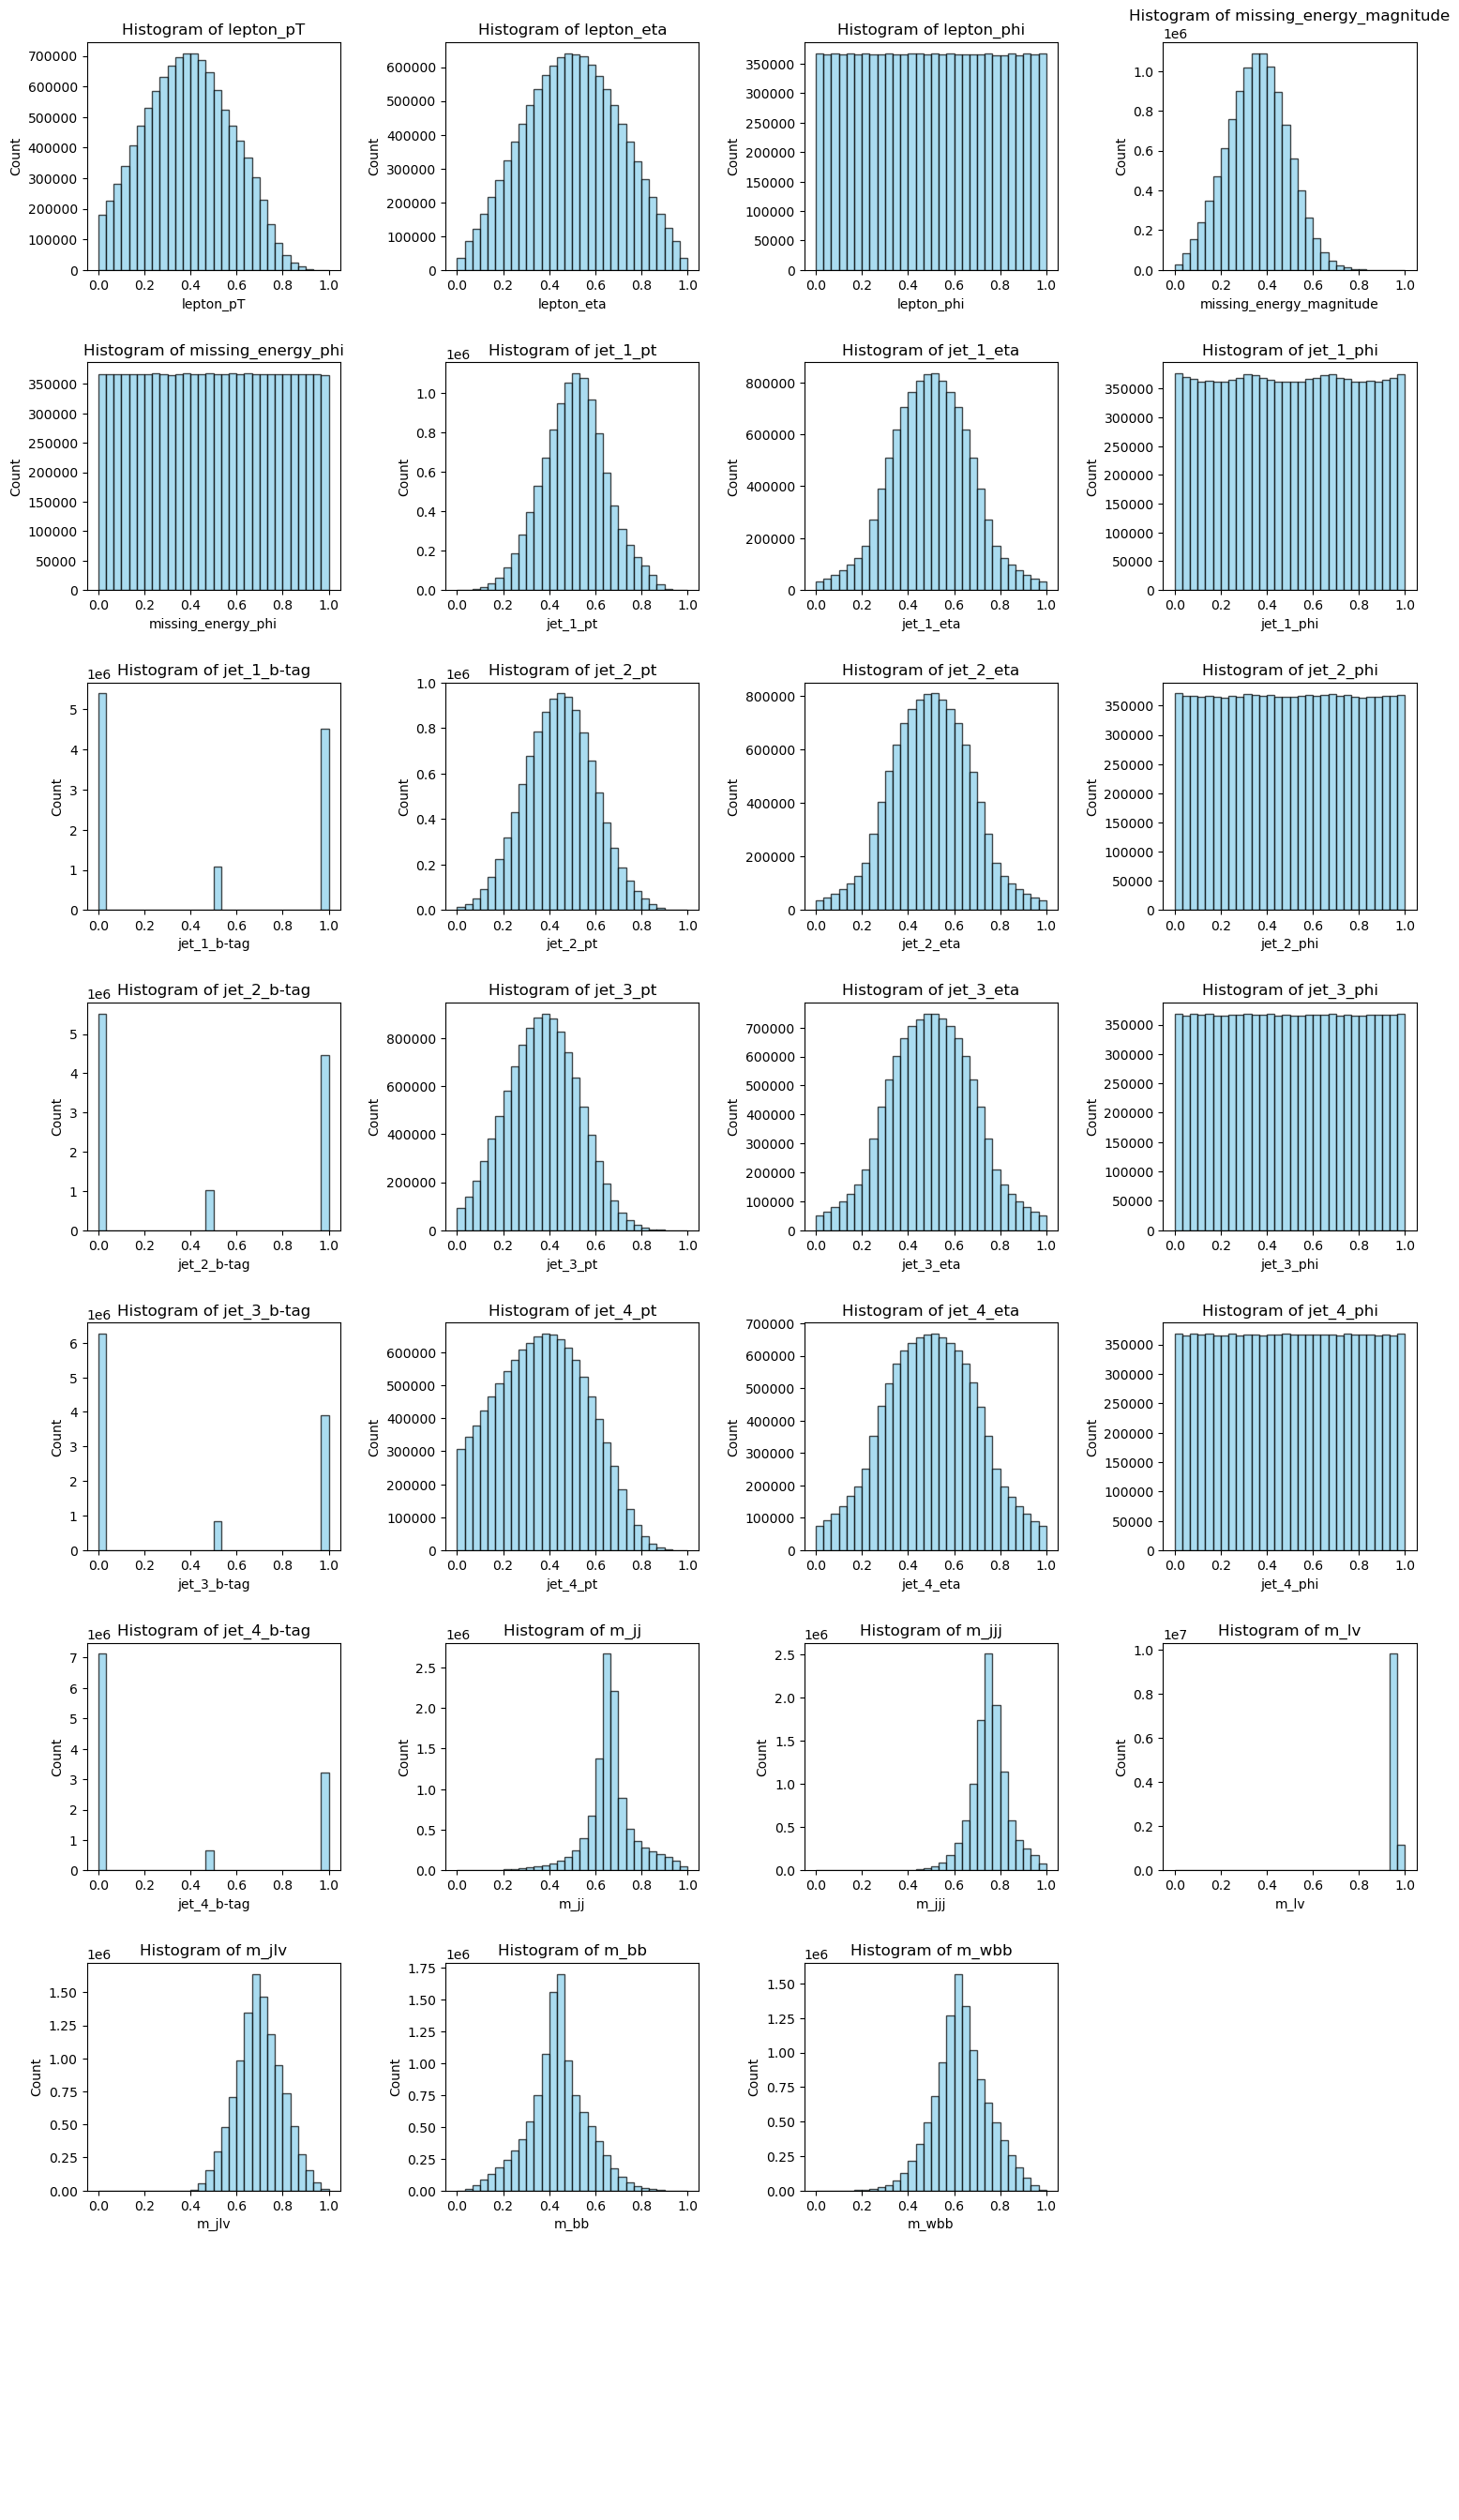

In [15]:
if show_graphs:
    display_data_disp(X)

# 4. Dimensionality Reduction

In this section we will split the dataset into 3 sets:
 - train 80% used to train the models 
 - test 10% test the prediction of the models in the training process
 - validation 10% used to evaluate the models

after that we are going to use 2 metods of Dimensionality Reduction:

 - PCA
 - feature Importance

we will compare the result of both methods and conclude which one is best for the dataset

In [16]:
def split_dataset(X, y, train_frac=0.8, val_frac=0.1, test_frac=0.1, random_state=42):
    assert abs(train_frac + val_frac + test_frac - 1.0) < 1e-6, "Fractions must sum to 1."

    n_samples = len(X)
    cp.random.seed(random_state)
    indices = cp.random.permutation(n_samples)

    train_end = int(train_frac * n_samples)
    val_end = train_end + int(val_frac * n_samples)

    train_idx = indices[:train_end]
    val_idx = indices[train_end:val_end]
    test_idx = indices[val_end:]

    # Convert to cuDF Series for indexing
    train_idx = cudf.Series(train_idx)
    val_idx = cudf.Series(val_idx)
    test_idx = cudf.Series(test_idx)

    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [17]:
def perform_PCA(X, n_components=None, variance_threshold=0.95):
    """
    Performs PCA on large GPU-based data with optional automatic component selection.

    Parameters:
        X (cuDF.DataFrame): Feature matrix (excluding target column).
        n_components (int, optional): Number of PCA components. If None, it will be chosen based on variance_threshold.
        variance_threshold (float, optional): Target cumulative variance if n_components is None.

    Returns:
        X_pca_gpu (cp.ndarray): Transformed data.
        explained_variance (np.ndarray): Explained variance ratio for each component.
        pca (cuml.PCA): Trained PCA model.
    """
    batch_size = 500000
    num_batches = (X.shape[0] // batch_size)
    scaler = StandardScaler()

    scaled_chunks = []

    # Process data in batches
    for i in range(num_batches):
        start = i * batch_size
        end = min((i + 1) * batch_size, X.shape[0])
        X_batch = X.iloc[start:end, :]  # Select the features only

        # Scale the batch (GPU-based scaling)
        X_scaled_batch = scaler.fit_transform(X_batch).to_cupy()
        scaled_chunks.append(X_scaled_batch)

    # Concatenate all scaled batches into one array
    X_scaled_gpu = cp.concatenate(scaled_chunks, axis=0)

    if n_components is None:
        # Temporarily fit with all components to calculate cumulative variance
        pca_temp = PCA()
        X_temp = pca_temp.fit_transform(X_scaled_gpu)
        cum_var = cp.cumsum(pca_temp.explained_variance_ratio_).get()
        
        # Select the number of components based on the variance threshold
        n_components = np.argmax(cum_var >= variance_threshold) + 1
        print(f"📌 Automatically selected n_components = {n_components} to retain {variance_threshold*100:.0f}% variance.")

    # Final PCA with the selected number of components
    start_time = time.time()
    pca = PCA(n_components=n_components)
    X_pca_gpu = pca.fit_transform(X_scaled_gpu)
    end_time = time.time()

    explained_variance = pca.explained_variance_ratio_.get()

    # Plot cumulative explained variance
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o', linestyle='--', color='b')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance (GPU)')
    plt.grid()
    plt.show()

    print("✅ PCA completed on GPU.")
    print(f"🔹 Total Explained Variance: {explained_variance.sum():.4f}")
    print(f"🔹 Time Taken: {end_time - start_time:.2f} seconds")
    print(f"🔹 PCA Output Shape: {X_pca_gpu.shape}")
    
    # Convert to cuDF DataFrame
    X_pca_cudf = cudf.DataFrame(X_pca_gpu, columns=[f"PC{i+1}" for i in range(n_components)])

    return X_pca_cudf

## PCA 
Using PCA we have been able to reduce the number of fetures to 23 and keep a CEV of 95%

[W] [21:06:15.397179] Warning(`fit`): As of v0.16, PCA invoked without an n_components argument defaults to using min(n_samples, n_features) rather than 1
📌 Automatically selected n_components = 23 to retain 95% variance.


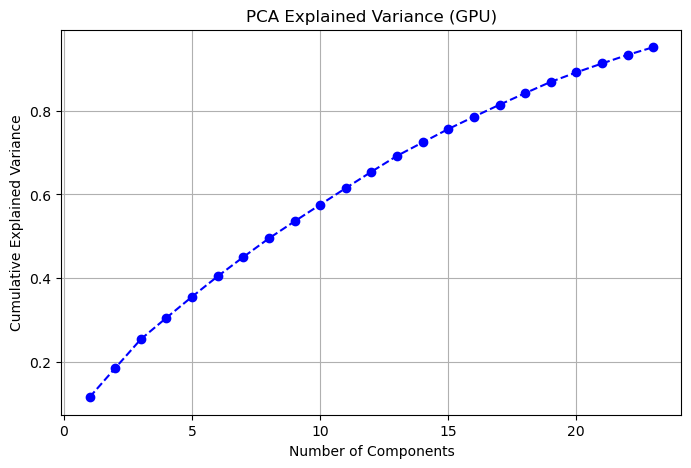

✅ PCA completed on GPU.
🔹 Total Explained Variance: 0.9524
🔹 Time Taken: 0.46 seconds
🔹 PCA Output Shape: (11000000, 23)


In [18]:
pca_x=perform_PCA(X)

In [19]:
 X_train_pca, X_val_pca, X_test_pca, y_train_pca, y_val_pca, y_test_pca=split_dataset(pca_x,y)

In [20]:
def feature_importance(X):
    X_filtered=X
    # Ensure X_filtered and y are cudf.DataFrames
    X_filtered_pd = X_filtered.to_pandas()
    y_pd = y.to_pandas()
    
    # Train XGBoost model on GPU
    model = xgb.XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
    model.fit(X_filtered_pd, y_pd)
    
    # Get feature importances
    importances = model.feature_importances_
    
    # Convert to cudf for efficient GPU operations
    feature_importance_df = cudf.DataFrame({
        "feature": X_filtered.columns,
        "importance": importances
    })
    
    importances_list = importances.tolist()
    
    # Set threshold dynamically (e.g., keep top N% instead of fixed 0.01)
    top_n_percent = 0.2  # Keep top 20% most important features
    threshold = np.percentile(importances, (1 - top_n_percent) * 100)
    important_features = [f for f, score in zip(X_filtered.columns, importances_list) if score >= threshold]
    
    
    # Select only important features
    X_important = X_filtered[important_features]
    print(important_features)
    return X_important


## Feature Importance

Using the top 20% feature which are missing_energy_magnitude, jet_1_pt, m_jjj, m_jlv, m_bb, m_wbb.

In [21]:
X=feature_importance(X)

['missing_energy_magnitude', 'jet_1_pt', 'm_jjj', 'm_jlv', 'm_bb', 'm_wbb']


In [22]:
 X_train, X_val, X_test, y_train, y_val, y_test=split_dataset(X,y)

# 5. GPU-Based Solution

In this section we will train 2 models XGboost and Rendom Forest using both reduced dataset from PCA and feature Importance using GPU and CPU to see which is better

In [23]:
def train_models_gpu(X_train, y_train, X_val, y_val):
    results = {}
    # Convert target to pandas for CPU models
    y_train_cpu = y_train.to_pandas()
    y_val_cpu = y_val.to_pandas()

    xgb_gpu_params = {
        'n_estimators': 300,
        'max_depth': 8,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,
        'reg_lambda': 1.0,
        'tree_method': 'hist',
        'random_state': 42,
        'verbosity': 0
    }

    xgb_gpu_params = xgb_gpu_params.copy()
    xgb_gpu_params['tree_method'] = 'gpu_hist'
    # GPU XGBoost
    start = time.time()
    xgb_gpu = xgb.XGBClassifier(**xgb_gpu_params)
    xgb_gpu.fit(X_train.to_pandas(), y_train_cpu)
    duration = time.time() - start
    acc = xgb_gpu.score(X_val.to_pandas(), y_val_cpu)
    results['XGBoost GPU'] = (duration, acc)
    
    rf_gpu_params = {
        'n_estimators': 50,
        'max_depth': 8,
        'bootstrap': True,
        'random_state': 42
        # Note: cuML RF doesn't support max_features
    }

    # GPU RF
    start = time.time()
    rf_gpu = cuRF(**rf_gpu_params)
    rf_gpu.fit(X_train, y_train)
    preds = rf_gpu.predict(X_val)
    duration = time.time() - start
    acc = (preds == y_val).mean()
    results['Random Forest GPU'] = (duration, acc.item())

    # ====================== Results =========================
    print("\n🔍 Training Time and Accuracy Summary:")
    for model, (time_taken, accuracy) in results.items():
        print(f"{model:<20} | ⏱ {time_taken:.2f}s | 🎯 Accuracy: {accuracy:.4f}")
    models=[rf_gpu,xgb_gpu]
    
    return models

## GPU + Feature Importance
We can see that the models have trained super quickly and we obtaind some pretty solid results

In [24]:
# Run training + timing
gpu_models = train_models_gpu(X_train, y_train, X_val, y_val)

/home/msc1/miniconda3/envs/rapids-23.08/lib/python3.9/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/msc1/miniconda3/envs/rapids-23.08/lib/python3.9/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)



🔍 Training Time and Accuracy Summary:
XGBoost GPU          | ⏱ 8.05s | 🎯 Accuracy: 0.7010
Random Forest GPU    | ⏱ 14.69s | 🎯 Accuracy: 0.6828


## GPU + PCA
Model training took a bit longer but still fast. the result are worst then the XGBoost with a dorp on speed and accuracy

In [25]:
# Run training + timing
gpu_models_pca = train_models_gpu(X_train_pca, y_train_pca, X_val_pca, y_val_pca)

/home/msc1/miniconda3/envs/rapids-23.08/lib/python3.9/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/msc1/miniconda3/envs/rapids-23.08/lib/python3.9/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)



🔍 Training Time and Accuracy Summary:
XGBoost GPU          | ⏱ 23.19s | 🎯 Accuracy: 0.6856
Random Forest GPU    | ⏱ 19.31s | 🎯 Accuracy: 0.6139


### When we used 40% of the top features (9 features) in the feature importance we got:

🔍 Training Time and Accuracy Summary:

XGBoost GPU          | ⏱ 9.08s | 🎯 Accuracy: 0.728

3
Random Forest GPU    | ⏱ 16.07s | 🎯 Accuracy: 0.6883

# 5. CPU-Based Solution

In [26]:
def train_models_cpu(X_train, y_train, X_val, y_val):
    results = {}
    xgb_cpu_params = {
        'n_estimators': 300,
        'max_depth': 8,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,
        'reg_lambda': 1.0,
        'tree_method': 'hist',
        'random_state': 42,
        'verbosity': 0
    }
    # Convert target to pandas for CPU models
    y_train_cpu = y_train.to_pandas()
    y_val_cpu = y_val.to_pandas()

    # ====================== XGBoost =========================

    # CPU XGBoost
    start = time.time()
    xgb_cpu = xgb.XGBClassifier(**xgb_cpu_params)
    xgb_cpu.fit(X_train.to_pandas(), y_train_cpu)
    duration = time.time() - start
    acc = xgb_cpu.score(X_val.to_pandas(), y_val_cpu)
    results['\n\nXGBoost CPU'] = (duration, acc)
    
    # ================= Random Forest ========================
    rf_cpu_params = {
        'n_estimators': 50,
        'max_depth': 8,
        'max_features': 'sqrt',
        'bootstrap': True,
        'random_state': 42
    }

    # CPU RF
    start = time.time()
    rf_cpu = skRF(**rf_cpu_params)
    rf_cpu.fit(X_train.to_pandas(), y_train_cpu)
    duration = time.time() - start
    acc = rf_cpu.score(X_val.to_pandas(), y_val_cpu)
    results['Random Forest CPU'] = (duration, acc)
    
   # ====================== Results =========================
    print("\n🔍 Training Time and Accuracy Summary:")
    for model, (time_taken, accuracy) in results.items():
        print(f"{model:<20} | ⏱ {time_taken:.2f}s | 🎯 Accuracy: {accuracy:.4f}")
    models=[rf_cpu,xgb_cpu]
    
    return models

## CPU + Feature Importance
The models took too long to train using the small set of features and the results are worst.

Training the models using the PCA dataset will be too long and will result in lower accuracy so we are not going to do it 

In [27]:
cpu_models = train_models_cpu(X_train, y_train, X_val, y_val)


🔍 Training Time and Accuracy Summary:


XGBoost CPU        | ⏱ 87.65s | 🎯 Accuracy: 0.7010
Random Forest CPU    | ⏱ 1046.24s | 🎯 Accuracy: 0.6855


# 7. Evaluation

In [53]:
def evaluation_gpu(X_test, y_test, model_list):
    # Convert cuDF to NumPy arrays (only once, at the beginning)
    X_test_np = X_test.to_numpy()
    y_test_np = y_test.to_numpy()

    # Model names for printing and labeling plots
    model_names = ["XGBoost", "RandomForest"][:len(model_list)]

    for i, model in enumerate(model_list):
        name = model_names[i]
        y_pred = model.predict(X_test_np)
        y_prob = model.predict_proba(X_test_np)[:, 1]

        print(f"\n--- {name} ---")
        print("Confusion Matrix:\n", confusion_matrix(y_test_np, y_pred))
        print("Classification Report:\n", classification_report(y_test_np, y_pred))

        auc = roc_auc_score(y_test_np, y_prob)
        print(f"ROC-AUC: {auc:.2f}")

        # ROC curve
        fpr, tpr, _ = roc_curve(y_test_np, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

    # Final plot formatting
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title("ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()



--- XGBoost ---
Confusion Matrix:
 [[201183 316527]
 [108234 474056]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.39      0.49    517710
         1.0       0.60      0.81      0.69    582290

    accuracy                           0.61   1100000
   macro avg       0.62      0.60      0.59   1100000
weighted avg       0.62      0.61      0.59   1100000

ROC-AUC: 0.66

--- RandomForest ---
Confusion Matrix:
 [[312510 205200]
 [140666 441624]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.69      0.60      0.64    517710
         1.0       0.68      0.76      0.72    582290

    accuracy                           0.69   1100000
   macro avg       0.69      0.68      0.68   1100000
weighted avg       0.69      0.69      0.68   1100000

ROC-AUC: 0.75


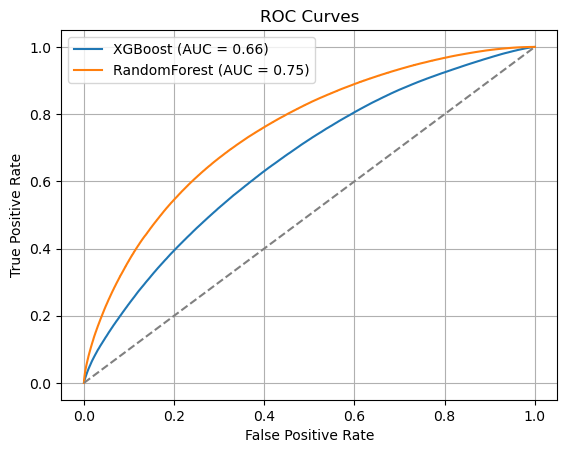

In [54]:
evaluation_gpu(X_val_pca, y_val_pca,gpu_models_pca)

## GPU vs CPU results 

The results produced by the GPU-trained models are identical to those obtained using CPU-based models. However, training on the GPU is significantly faster — approximately 10× faster for XGBoost and 75× faster for Random Forest.

Based on these results, we can conclude that using a CPU offers no practical advantage over GPU training. Additionally, while XGBoost shows a slightly lower AUC score (by just 0.02), its dramatically faster training time makes it the more suitable choice for this task.

When evaluating feature selection techniques, it was found that using 20% Feature Importance (FI) performed better overall. Although using 40% FI slightly improved the model's accuracy by 0.02, it introduced 5 additional features, increasing computational cost without delivering a proportionate performance benefit. Furthermore, the use of Principal Component Analysis (PCA) was less effective in this case, the PCA transformation resulted in 23 components, and the model's performance was noticeably worse compared to using 20% FI-selected features. Therefore, selecting the top 20% most important features offers the best balance between model performance and computational efficiency.


--- XGBoost ---
Confusion Matrix:
 [[329238 188472]
 [160404 421886]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.67      0.64      0.65    517710
         1.0       0.69      0.72      0.71    582290

    accuracy                           0.68   1100000
   macro avg       0.68      0.68      0.68   1100000
weighted avg       0.68      0.68      0.68   1100000

ROC-AUC: 0.75

--- RandomForest ---
Confusion Matrix:
 [[353551 164159]
 [164790 417500]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.68      0.68      0.68    517710
         1.0       0.72      0.72      0.72    582290

    accuracy                           0.70   1100000
   macro avg       0.70      0.70      0.70   1100000
weighted avg       0.70      0.70      0.70   1100000

ROC-AUC: 0.77


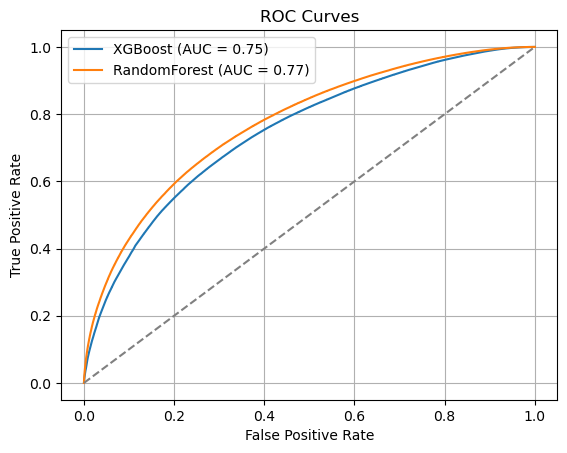

In [55]:
evaluation_gpu(X_val, y_val,gpu_models)

/home/msc1/miniconda3/envs/rapids-23.08/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/msc1/miniconda3/envs/rapids-23.08/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



--- XGBoost ---
Confusion Matrix:
 [[335210 182500]
 [163466 418824]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.67      0.65      0.66    517710
         1.0       0.70      0.72      0.71    582290

    accuracy                           0.69   1100000
   macro avg       0.68      0.68      0.68   1100000
weighted avg       0.69      0.69      0.69   1100000

ROC-AUC: 0.75

--- RandomForest ---
Confusion Matrix:
 [[353481 164229]
 [164709 417581]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.68      0.68      0.68    517710
         1.0       0.72      0.72      0.72    582290

    accuracy                           0.70   1100000
   macro avg       0.70      0.70      0.70   1100000
weighted avg       0.70      0.70      0.70   1100000

ROC-AUC: 0.77


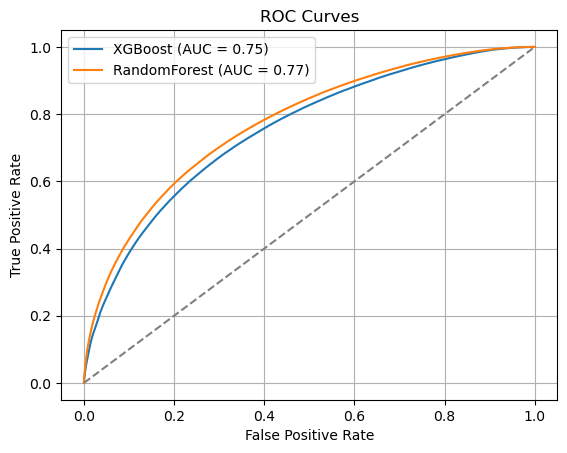

In [56]:
evaluation_gpu(X_val, y_val,cpu_models)